In [1]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy

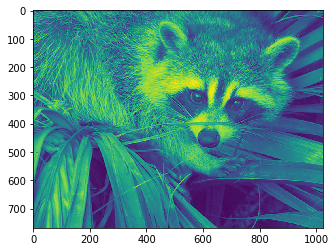

In [2]:
face = misc.face()
data = face[:,:,0] / 255
plt.imshow(data)

In [3]:
data.shape

(768, 1024)

In [4]:
m = 768 # number of data points
n = 1024 # dimensional of data
A = data # data matrix
l = 100 # dimension of low diml space

iterations = 20

In [5]:
def random_svd_rank_k(matrix, k):
    omega = random.randn(matrix.shape[1],k)
    Y = A @ omega
    q, r = np.linalg.qr(Y)
    return q @ q.T @ matrix

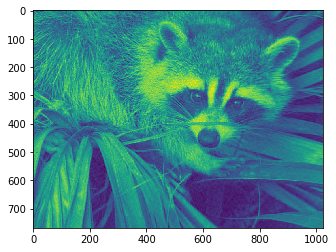

In [6]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
approx = pca.inverse_transform(pca.fit_transform(data))
plt.imshow(approx)

In [7]:
#fig, ax = plt.subplots(1,3, figsize=(15,15))
#ax[0].imshow(data)
#ax[1].imshow(example)
#ax[2].imshow(approx)

In [8]:
def svd_rank_k(matrix, k):
    u, sigma, vh = np.linalg.svd(matrix) #compute full svd
    u = u[:,:k] #keep all rows, take first k columns
    sigma = np.diag(sigma[:k]) #take first k singular values and make diagonal matrix
    vh = vh[:k] #take first k rows, take all columns
    return u @ sigma @ vh #return rank k approximation

In [90]:
def id_rank_k(matrix, k):
    q, r, p = scipy.linalg.qr(matrix, pivoting=True)
    q = q[:,:k]
    return q @ q.T @ matrix

In [87]:
def proj(v,u): #projection of v onto u
    return (np.dot(v,u) / np.dot(u,u)) * u

def id_rank_k_slow(matrix, k):
    
    m = np.copy(matrix) #starts out as full matrix
    indices = []
        
    if False:
        indices = predetermined[:k]
    else:
        #Greedy determinant maximization process
        for j in range(k):
            col_norms = np.zeros(matrix.shape[1])
            for ind in np.delete(np.arange(matrix.shape[1]), indices): #loop through non-chosen columns
                col_norms[ind] = np.linalg.norm(m[:,ind]) #gets norms of non-chosen columns
            max_norm_index = np.argmax(col_norms) #index of column with greatest l2 norm

            indices.append(max_norm_index) #add the index to a list of indices

            #orthogonalize columns with all other indices
            for i in np.delete(np.arange(matrix.shape[1]), indices):   #iterate over all other indices and do g-s step
                for ind in indices:
                    m[:,i] = m[:,i] - proj(m[:,i],m[:,ind])

    Ak = matrix[:,indices] # first k columns of A
    Other = matrix[:,np.delete(np.arange(matrix.shape[1]),indices)] # other columns of A
    AP = np.concatenate((Ak,Other),axis=1) # combine it so we have the data, A, reordered, with the 'best' k coming first

    q,r = np.linalg.qr(AP) #now compute QR
    q = q[:,:k] # and take the first k, corresponding to the 'best' k from A

    return q @ q.T @ matrix
    

In [10]:
def random_id_rank_k(matrix, k, p):
    if(p<=k or p>n):
        print('Invalid p')
        return False
    cols = np.random.choice(matrix.shape[1], replace = False, size = p)
    AS = matrix[:,cols]
    q,r = np.linalg.qr(AS)
    q = q[:,:k]
    return q @ q.T @ matrix

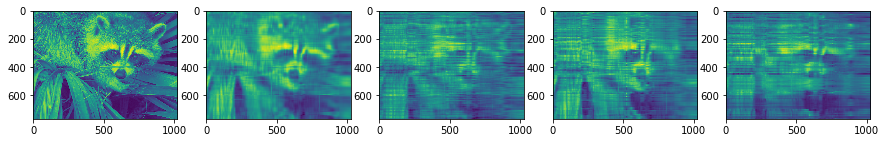

In [89]:
fig, ax = plt.subplots(1,5, figsize=(15,15))
ax[0].imshow(data)
ax[1].imshow(svd_rank_k(data, 10))
ax[2].imshow(random_svd_rank_k(data, 10))
ax[3].imshow(id_rank_k(data, 10))
ax[4].imshow(random_id_rank_k(data, 10, 15))

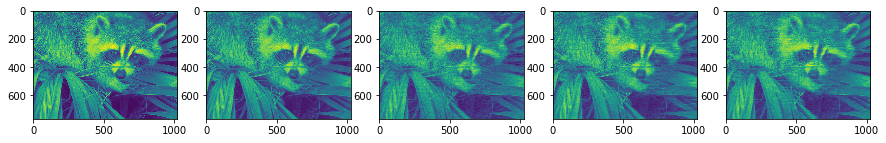

In [91]:
fig, ax = plt.subplots(1,5, figsize=(15,15))
ax[0].imshow(data)
ax[1].imshow(svd_rank_k(data, 100))
ax[2].imshow(random_svd_rank_k(data, 100))
ax[3].imshow(id_rank_k(data, 100))
ax[4].imshow(random_id_rank_k(data, 100, 101))

In [93]:
k_domain = np.array([8,16,32,64,128,256])
error_svd = np.empty(k_domain.shape[0])
error_id = np.empty(k_domain.shape[0])

for i,val in enumerate(k_domain):
    error_svd[i] = np.linalg.norm(data - svd_rank_k(data, val)) / np.linalg.norm(data)
    error_id[i] = np.linalg.norm(data - id_rank_k(data, val)) / np.linalg.norm(data)
    


In [94]:
# for random procedures, calculate mean and IQR

error_random_svd = np.empty((7,k_domain.shape[0]))
error_random_id = np.empty((7, k_domain.shape[0]))

iterations = 100

for i,val in enumerate(k_domain):
    err_rsvd = np.empty(iterations)
    err_rid = np.empty(iterations)

    for j in range(iterations):
        err_rsvd[j] = np.linalg.norm(data - random_svd_rank_k(data, val)) / np.linalg.norm(data)
        err_rid[j] = np.linalg.norm(data - random_id_rank_k(data, val, val+10)) / np.linalg.norm(data)
    error_random_svd[0][i] = np.quantile(err_rsvd, 0.25)
    error_random_svd[1][i] = np.median(err_rsvd)
    error_random_svd[2][i] = np.quantile(err_rsvd, 0.75)
    error_random_svd[3][i] = np.mean(err_rsvd)
    error_random_svd[4][i] = np.std(err_rsvd)
    error_random_svd[5][i] = np.min(err_rsvd)
    error_random_svd[6][i] = np.max(err_rsvd)

    error_random_id[0][i] = np.quantile(err_rid, 0.25)
    error_random_id[1][i] = np.median(err_rid)
    error_random_id[2][i] = np.quantile(err_rid, 0.75)
    error_random_id[3][i] = np.mean(err_rid)
    error_random_id[4][i] = np.std(err_rid)
    error_random_id[5][i] = np.min(err_rid)
    error_random_id[6][i] = np.max(err_rid)


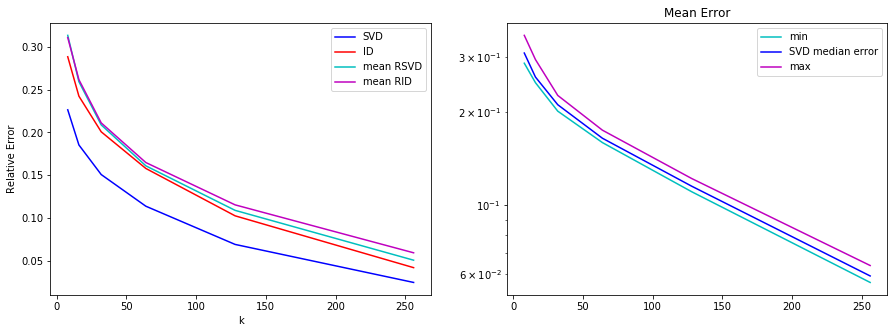

In [98]:
# Mean errors on the same graph
fig, ax = plt.subplots(1,2, figsize=(15,5))

plt.yscale('log')
ax[0].plot(k_domain, error_svd, c='b', label='SVD')
ax[0].plot(k_domain, error_id, c='r', label='ID')
ax[0].plot(k_domain, error_random_svd[3], c='c', label='mean RSVD')
ax[0].plot(k_domain, error_random_id[3], c='m', label='mean RID')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
ax[0].legend(loc='upper right')
plt.title('Mean Error')

#plt.yscale('log')
ax[1].plot(k_domain, error_random_id[5], c='c', label='min')
ax[1].plot(k_domain, error_random_id[1], c='b', label='SVD median error')
ax[1].plot(k_domain, error_random_id[6], c='m', label='max')
ax[1].legend(loc='upper right')
#ax[1].plot(k_domain, error_random_id[0], c='b', label='SVD')
#ax[1].plot(k_domain, error_random_id[1], c='b', label='SVD')
#ax[1].plot(k_domain, error_random_id[2], c='b', label='SVD')

plt.show()

array([0.05061812, 0.05061823, 0.05071052, 0.05076679, 0.05056029,
       0.05046872, 0.05089985, 0.05094714, 0.05067934, 0.05062091,
       0.05061515, 0.05041699, 0.05086802, 0.05062694, 0.05079804,
       0.05068768, 0.05032685, 0.05063823, 0.05039698, 0.05087453,
       0.05092722, 0.0507737 , 0.05065412, 0.05068369, 0.05055786,
       0.05081677, 0.04998033, 0.05066615, 0.05060894, 0.05030613,
       0.05032873, 0.05059126, 0.05066838, 0.05039195, 0.05106056,
       0.0502857 , 0.05056567, 0.05069386, 0.05037095, 0.05053004,
       0.05044557, 0.05087636, 0.05103852, 0.05084966, 0.05084943,
       0.05091318, 0.05063389, 0.05051146, 0.05075451, 0.05040061,
       0.05080692, 0.05045298, 0.0506148 , 0.05074055, 0.0513057 ,
       0.0504997 , 0.05042179, 0.05090715, 0.05103746, 0.05046797,
       0.05083437, 0.05057151, 0.05056267, 0.05058957, 0.0508168 ,
       0.05011516, 0.05082767, 0.05098429, 0.05066   , 0.05062821,
       0.05073479, 0.05077277, 0.05073556, 0.05043926, 0.05101